In [ ]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


countries_display = {
    "US": "United States",
    "PT": "Portugal",
    "ES": "Spain",
    "GB": "Great Britain and\nNorthern Ireland",
    "FR": "France",
    "IT": "Italy",
    "DE": "Germany",
    "CA": "Canada",
    "CN": "China",
    "IN": "India",
}

subfields_display = {
    "Computer Vision and Pattern Recognition": "Computer Vision \nand Pattern Recognition",
    "Information Systems": "Information Systems",
    "Computational Theory and Mathematics": "Computational Theory \nand Mathematics",
    "Artificial Intelligence": "Artificial Intelligence",
    "Computer Networks and Communications": "Computer Networks \nand Communications",
    "Computer Science Applications": "Computer Science \nApplications",
    "Software": "Software",
    "Signal Processing": "Signal Processing",
    "Human-Computer Interaction": "Human-Computer Interaction",
    "Hardware and Architecture": "Hardware \nand Architecture",
    "Computer Graphics and Computer-Aided Design": "Computer Graphics and \nComputer-Aided Design",
}


def combine_dfs(df1, df2, df3, df4, df5, df6) -> pd.DataFrame:
    df1 = df1.dropna(how="all")
    df2 = df2.dropna(how="all")
    df3 = df3.dropna(how="all")
    df4 = df4.dropna(how="all")
    df5 = df5.dropna(how="all")
    df6 = df6.dropna(how="all")
    df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)
    return df


def get_authors_country_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generates a DataFrame with the counts and percentage of authors' countries (excluding 'BR')
    from the 'authorships' column of the input DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing an 'authorships' column.

    Returns:
        pd.DataFrame: A DataFrame with three columns:
                      'authors_country', 'count', and 'percentage'
                      where 'percentage' represents the percentage of total collaborations.
    """
    country_counter = Counter()

    for _, row in df.iterrows():
        # Parse the JSON string from the authorships column
        try:
            authors_list = json.loads(row["authorships"])
        except json.JSONDecodeError:
            continue  # skip rows that cannot be parsed

        # Loop through each author in the list
        for author in authors_list:
            # Retrieve the list of countries for this author
            countries = author.get("countries", [])
            for country in countries:
                # Exclude 'BR' as instructed
                if country != "BR":
                    country_counter[country] += 1

    # Convert the counter to a DataFrame
    result_df = pd.DataFrame(
        list(country_counter.items()), columns=["authors_country", "count"]
    )

    # Calculate the total count of collaborations (all countries)
    total_count = result_df["count"].sum()

    # Compute the percentage that each country's count represents
    result_df["percentage"] = result_df["count"] / total_count * 100

    # Sort the DataFrame by count in descending order
    result_df.sort_values(by="count", ascending=False, inplace=True)
    result_df.reset_index(drop=True, inplace=True)
    result_df["position"] = result_df.index + 1

    return result_df


def filter_subfielf_publications(df: pd.DataFrame, subfiled: str) -> pd.DataFrame:
    """
    Filters the DataFrame to include only publications where the
    subfield's display_name is 'Artificial Intelligence'.

    The function assumes that the 'subfield' column contains a JSON string.
    """
    # Use a lambda to parse the JSON and check the display_name
    filtered_df = df[
        df["subfield"].apply(lambda x: json.loads(x).get("display_name") == subfiled)
    ]
    return filtered_df


def filter_publications_by_citation_count(
    df: pd.DataFrame, num_citations: int
) -> pd.DataFrame:
    """
    Filters the DataFrame to include only publications with more than the specified number of citations.
    """
    filtered_df = df[df["cited_by_count"] > num_citations]
    return filtered_df



def plot_subfield_country_heatmap(df, normalize=True):
    # Define subfields and their display order
    subfield_order = [
        "Computer Vision and Pattern Recognition",
        "Information Systems",
        "Computational Theory and Mathematics",
        "Artificial Intelligence",
        "Computer Networks and Communications",
        "Computer Science Applications",
        "Software",
        "Signal Processing",
        "Human-Computer Interaction",
        "Hardware and Architecture",
        "Computer Graphics and Computer-Aided Design",
    ]

    subfield_order = sorted(subfield_order)

    # Define countries and their display order
    country_order = ["US", "PT", "ES", "GB", "FR", "IT", "DE", "CA", "CN", "IN"]

    # Parse JSON columns
    df["subfield"] = df["subfield"].apply(json.loads)
    df["authorships"] = df["authorships"].apply(json.loads)

    # Filter and prepare data
    valid_subfields = set(subfield_order)
    df["subfield_name"] = df["subfield"].apply(lambda x: x["display_name"])
    df = df[df["subfield_name"].isin(valid_subfields)]

    # Create count matrix
    count_matrix = pd.DataFrame(0, index=subfield_order, columns=country_order)

    # Calculate international collaborations (excluding BR-only authors)
    for _, row in df.iterrows():
        subfield = row["subfield_name"]
        for author in row["authorships"]:
            # Remove BR from countries and filter valid countries
            countries = [c for c in author.get("countries", []) if c != "BR"]
            valid_countries = [c for c in countries if c in country_order]

            # Count each valid country (multiple countries per author allowed)
            for country in valid_countries:
                count_matrix.loc[subfield, country] += 1

    # Convert country codes to display names
    count_matrix = count_matrix.rename(columns=countries_display)
    # Convert subfield names to display names
    count_matrix = count_matrix.rename(index=subfields_display)

    # Normalization logic
    if normalize:
        row_sums = count_matrix.sum(axis=1)
        normalized_matrix = count_matrix.div(row_sums, axis=0).fillna(0) * 100
        data_to_plot = normalized_matrix
        fmt = ".1f"
        cbar_label = "Percentage of International Authors"
    else:
        data_to_plot = count_matrix
        fmt = "d"
        cbar_label = "Number of International Authors"

    # Visualization
    plt.figure(figsize=(10, 8))
    fig = sns.heatmap(
        data_to_plot,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        cbar_kws={"label": cbar_label},
        linewidths=0.5,
        vmin=0,
        vmax=50 if normalize else None,
    )

    title = "Brazilian Publications: International Collaborations by Subfield"
    if normalize:
        title += "\n(Normalized Percentage of Non-Brazilian Authors)"
    else:
        title += "\n(Absolute Count of Non-Brazilian Authors)"

    plt.title(title, fontsize=14, pad=20)
    plt.xlabel("Collaborating Country", fontsize=12)
    plt.ylabel("Subfield", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    return fig


def summarize_subfield_publications(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each subfield, computes the number and percentage of publications that are:
      - Domestic only: all authors have affiliations exclusively to Brazilian institutions.
      - International collaborations: at least one author is affiliated with a non-Brazilian institution.

    The function returns a DataFrame with the following columns:
      - subfield_display: the subfield's display name.
      - domestic_publications: count of publications with only Brazilian affiliations.
      - international_publications: count of publications with any international affiliation.
      - total_publications: total count of publications for that subfield.
      - domestic_percentage: percentage of domestic publications.
      - international_percentage: percentage of international collaboration publications.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing at least 'authorships' and 'subfield' columns.

    Returns:
        pd.DataFrame: Summary table as described above.
    """

    # Helper function to parse the subfield display name
    def get_subfield_display(subfield_json: str):
        try:
            return json.loads(subfield_json).get("display_name")
        except (json.JSONDecodeError, TypeError):
            return None

    # Helper function to check if publication is domestic-only.
    # It returns True if every author has affiliations only to Brazil ("BR").
    def is_domestic_publication(authorships_json: str) -> bool:
        try:
            authors = json.loads(authorships_json)
        except (json.JSONDecodeError, TypeError):
            # if parsing fails, treat publication as not domestic
            return False
        for author in authors:
            countries = author.get("countries", [])
            # if any country is not "BR", then publication is international
            if any(country != "BR" for country in countries):
                return False
        return True

    # Create new columns in a copy of the DataFrame
    df = df.copy()
    df["subfield_display"] = df["subfield"].apply(get_subfield_display)
    df["is_domestic"] = df["authorships"].apply(is_domestic_publication)

    # Group by subfield and compute counts
    summary = (
        df.groupby("subfield_display")
        .agg(
            domestic_publications=("is_domestic", "sum"),
            total_publications=("is_domestic", "count"),
        )
        .reset_index()
    )

    # Calculate international counts and percentages
    summary["international_publications"] = (
        summary["total_publications"] - summary["domestic_publications"]
    )
    summary["domestic_percentage"] = (
        summary["domestic_publications"] / summary["total_publications"] * 100
    )
    summary["international_percentage"] = (
        summary["international_publications"] / summary["total_publications"] * 100
    )

    # Optional: Order columns for readability
    summary = summary[
        [
            "subfield_display",
            "domestic_publications",
            "international_publications",
            "total_publications",
            "domestic_percentage",
            "international_percentage",
        ]
    ]

    return summary

def plot_int_dom_summary(summary_dom_int_df):
    """
    Create a publication-quality visualization of international vs. domestic 
    collaboration in Brazilian computer science research.
    
    Parameters:
    -----------
    summary_dom_int_df : pandas.DataFrame
        DataFrame containing collaboration statistics with columns:
        - subfield_display: name of the computer science subfield
        - international_percentage: percentage of international collaborations
        - domestic_percentage: percentage of domestic collaborations
        - total_publications: total number of publications in the subfield
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the visualization
    """
    
    # Create a copy to avoid modifying the original
    df = summary_dom_int_df.copy()
    
    # Sort by international collaboration percentage (descending)
    df = df.sort_values('international_percentage', ascending=False).reset_index(drop=True)
    
    # Set up the matplotlib figure with research paper proportions
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Set the style to a clean, publication-ready theme
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.1)
    
    # Create the horizontal stacked bars
    # Use domain-appropriate colors - blue for international, warm gray for domestic
    colors = ["#1f77b4", "#d3d3d3"]  # Professional blue and light gray
    sns.barplot(x="international_percentage", y="subfield_display", data=df, 
                color=colors[0], label="International", ax=ax)
    sns.barplot(x="domestic_percentage", y="subfield_display", data=df, 
                color=colors[1], label="Domestic", left=df["international_percentage"], ax=ax)
    
    # Format the x-axis as percentage
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xlim(0, 100)
    
    # Clean up the axis labels and title for publication standards
    ax.set_xlabel("Percentage of Publications", fontsize=11)
    ax.set_ylabel("", fontsize=11)  # Remove y-axis label as it's self-explanatory
    ax.set_title("Distribution of Brazilian Computer Science Publications\nby Collaboration Type", fontsize=12, pad=10)
    
    # Add text annotations for percentages and publication counts
    for i, row in df.iterrows():
        int_pct = row['international_percentage']
        dom_pct = row['domestic_percentage']
        
        # Add international percentage if there's enough space
        if int_pct > 8:
            ax.text(int_pct/2, i, f"{int_pct:.1f}%", 
                    ha='center', va='center', color='white', fontweight='bold', fontsize=9)
        
        # Add domestic percentage if there's enough space
        if dom_pct > 15:
            ax.text(int_pct + dom_pct/2, i, f"{dom_pct:.1f}%", 
                    ha='center', va='center', color='black', fontweight='bold', fontsize=9)
        
        # Add the publication count information at the end of each bar
        ax.text(101, i, f"n={row['total_publications']:,}", 
                ha='left', va='center', fontsize=9, color='#555555')
    
    # Remove the top and right spines for a cleaner look
    sns.despine(top=True, right=True)
    
    # Adjust layout for best fit, but leave room at the bottom for legend
    plt.subplots_adjust(bottom=0.15)
    
    # Move legend to the bottom of the plot below the x-label
    # Use horizontal layout (ncol=2) to display legend items in a single row
    legend = ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.15),
        ncol=2, 
        frameon=False,
        borderaxespad=0
    )
    
    # Return the figure object
    return fig

In [2]:
DATA_PATH = "../data/csv/openalex/br_publications_"

df_2019 = pd.read_csv(DATA_PATH + "2019.csv")
df_2020 = pd.read_csv(DATA_PATH + "2020.csv")
df_2021 = pd.read_csv(DATA_PATH + "2021.csv")
df_2022 = pd.read_csv(DATA_PATH + "2022.csv")
df_2023 = pd.read_csv(DATA_PATH + "2023.csv")
df_2024 = pd.read_csv(DATA_PATH + "2024.csv")

br_publications_df = combine_dfs(df_2019, df_2020, df_2021, df_2022, df_2023, df_2024)
# br_publications_df.to_csv("../data/csv/openalex/br_publications.csv", index=False)

In [438]:
countries_collabs_df = get_authors_country_counts(br_publications_df)

In [439]:
# countries_collabs_df.head(10)

In [440]:
# ai_publications_df = filter_subfielf_publications(
#     br_publications_df, "Artificial Intelligence"
# )

In [441]:
# get_authors_country_counts(ai_publications_df).head(10)["authors_country"]

In [443]:
# authors_metrics_df.to_csv("../data/csv/openalex/authors_metrics.csv", index=False)

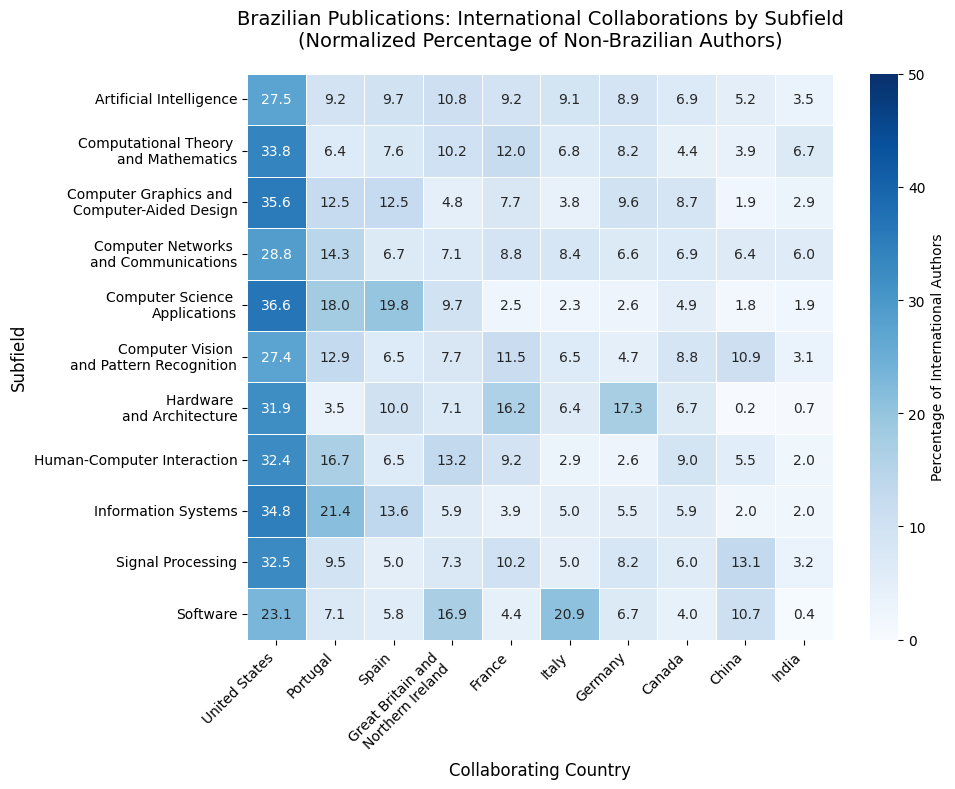

In [ ]:
plot_subfield_country_heatmap(br_publications_df)
# plt.savefig("../docs/inter_collabs_heatmap.pdf", format="pdf")
plt.show()

In [8]:
summarize_subfield_publications(br_publications_df)

,subfield_display,domestic_publications,international_publications,total_publications,domestic_percentage,international_percentage
0,Artificial Intelligence,6053,2681,8734,69.303870,30.696130
1,Computational Theory and Mathematics,1505,913,2418,62.241522,37.758478
2,Computer Graphics and Computer-Aided Design,133,67,200,66.500000,33.500000
3,Computer Networks and Communications,3066,1536,4602,66.623207,33.376793
4,Computer Science Applications,1418,500,1918,73.931178,26.068822
5,Computer Vision and Pattern Recognition,2638,1177,3815,69.148100,30.851900
6,Hardware and Architecture,419,208,627,66.826156,33.173844
7,Human-Computer Interaction,911,280,1191,76.490344,23.509656
8,Information Systems,14543,3186,17729,82.029443,17.970557
9,Signal Processing,877,355,1232,71.185065,28.814935


In [22]:
summary_dom_int_df = summarize_subfield_publications(br_publications_df)[
    ["subfield_display", "international_percentage", "international_publications", "domestic_percentage", "domestic_publications", "total_publications"]
]
summary_dom_int_df.sort_values(by='international_percentage', ascending=False, inplace=True)

In [29]:
summary_dom_int_df.columns

Index(['subfield_display', 'international_percentage',
       'international_publications', 'domestic_percentage',
       'domestic_publications', 'total_publications'],
      dtype='object')

In [16]:
len(br_publications_df)

42903

In [18]:
print(summary_dom_int_df['domestic_publications'].sum())
print(summary_dom_int_df['international_publications'].sum())
print(summary_dom_int_df['domestic_publications'].sum() + summary_dom_int_df['international_publications'].sum())

31878
11025
42903


In [24]:
summary_dom_int_df.to_csv("summary_dom_int.csv", index=False)

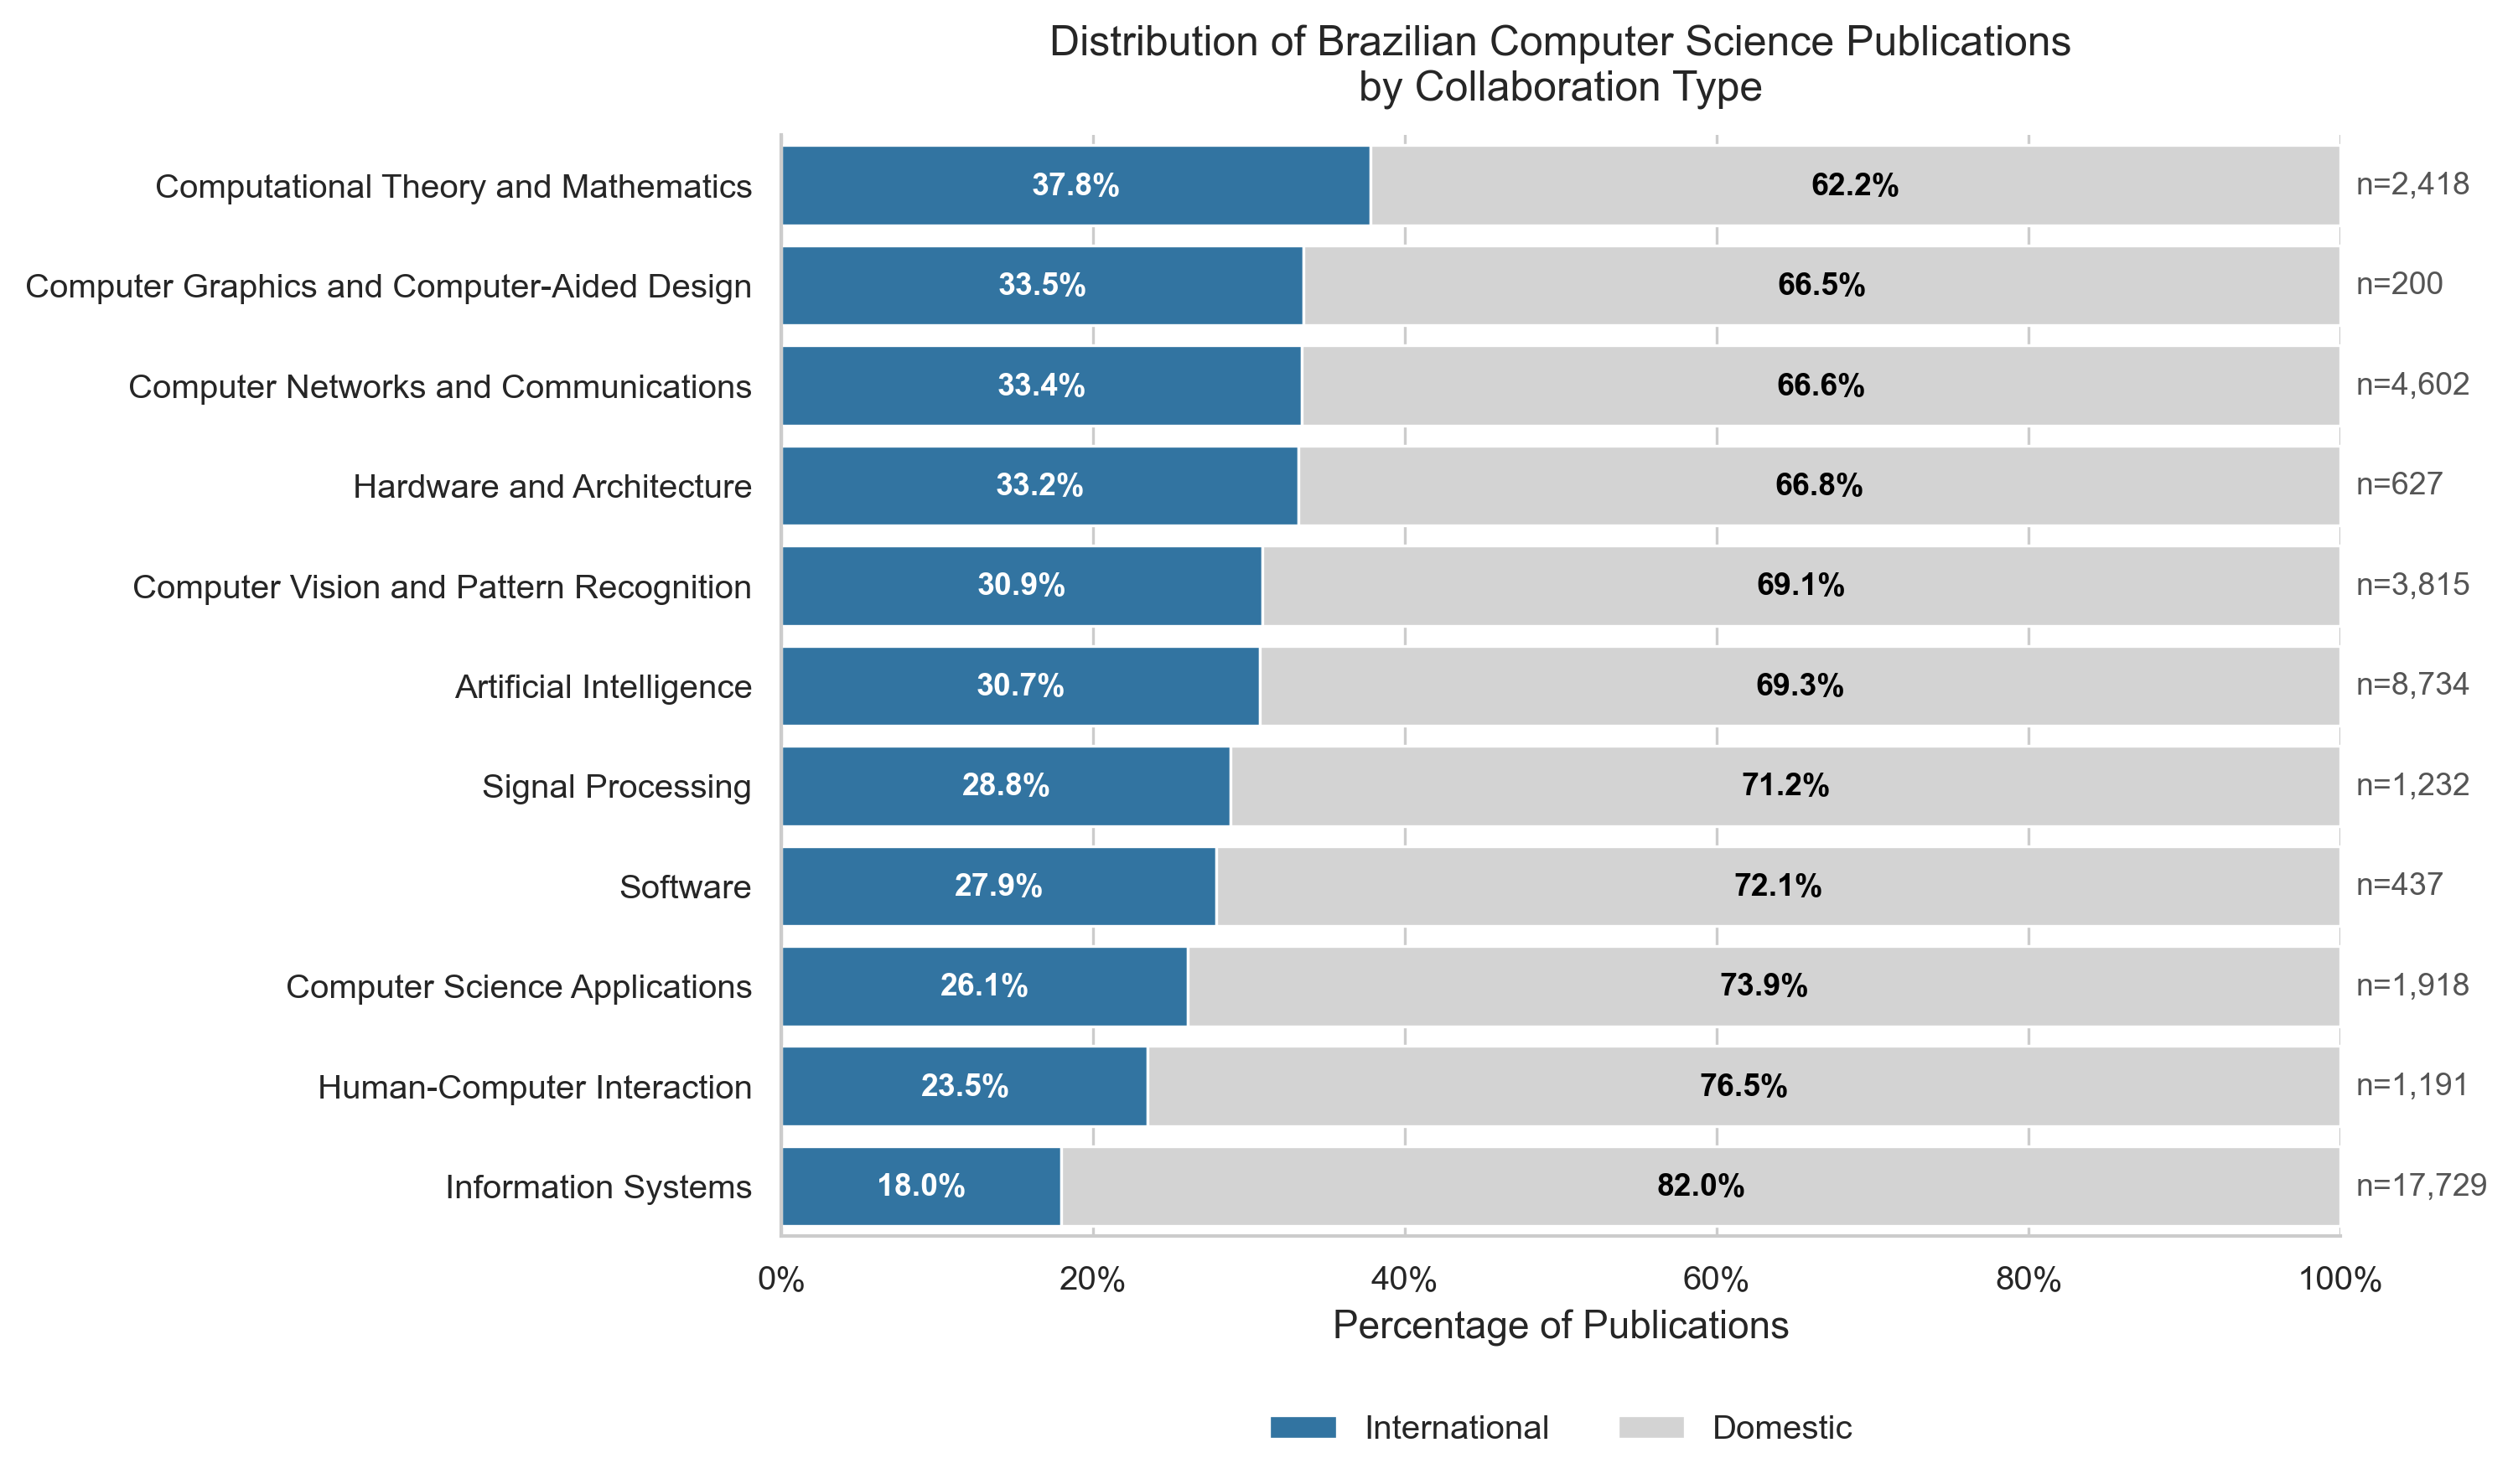

In [38]:
plot_int_dom_summary(summary_dom_int_df)
plt.show()